# Task 1

The purpose of this task is to classify the demand for bikes on a specific day using predefined labels. The first stage of this will be to find appropriate values to use for the labels.

<a id='content'></a>
## Contents:
- [Preprocessing](#prep) - can skip running as data is reloaded at the start of the models
- [Models](#mods)

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn import tree

<a id='prep'></a>
## Preprocessing
[Back to contents](#content)

In [2]:
# Read in the data
train_data = pd.read_csv("./data/preprocessed_data/train.csv")

For the dataset for this task, we need data about the day, but not about individual stations. There should be one entry for each morning and afternoon, together with the weather data or other features for the whole day.

In [3]:
# Keeping the feature data for each day
day_data_cols = ['year', 'month', 'day', 'weekday', 'isHoliday', 'isWeekend', 'mean_temperature', 'total_precipitation']
day_data = train_data[day_data_cols].drop_duplicates(subset=day_data_cols, keep='first')

# Grouping the ride counts for each am and pm
train_new = train_data[['year', 'month', 'day', 'am_pm', 'rides_count']].groupby(['year', 'month', 'day', 'am_pm'], as_index=False)['rides_count'].sum()
train_new = train_new.merge(day_data, how='left', on=['year', 'month', 'day'])

train_new.head()

,year,month,day,am_pm,rides_count,weekday,isHoliday,isWeekend,mean_temperature,total_precipitation
0,2014,4,15,False,742,1,False,False,5.6,9.0
1,2014,4,15,True,835,1,False,False,5.6,9.0
2,2014,4,16,False,2462,2,False,False,-3.4,0.0
3,2014,4,16,True,718,2,False,False,-3.4,0.0
4,2014,4,17,False,4178,3,False,False,2.4,0.0


Now this data has been created, want to examine the distribution with some plots. This should give ideas for the labels to use for categories of ride counts.

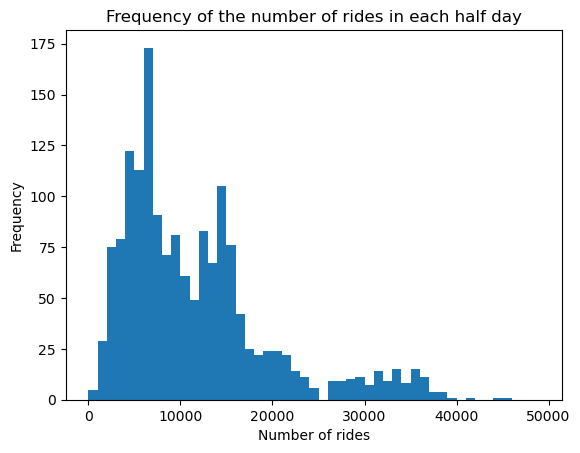

In [4]:
def dist_plot():
    plt.hist(train_new['rides_count'], bins=range(0,50000, 1000))

    plt.xlabel('Number of rides')
    plt.ylabel('Frequency')

dist_plot()
plt.title('Frequency of the number of rides in each half day')
plt.show()

It will be interesting to try different numbers of labels. For now, will create two versions. Three labels (low, medium and high) and five labels (very low, low, medium, high, very high). These will be implemented using numeric values for easier use later. These will be chosen by evenly dividing the data.

In [5]:
all_counts = list(train_new['rides_count'])
all_counts.sort()

# Thresholds for split into 3
label3_split = []
for i in range(1,3):
    label3 = all_counts[round(i*len(all_counts)/3)]
    label3_split.append(label3)

#Thresholds for split into 5
label5_split = []
for i in range(1,5):
    label5 = all_counts[round(i*len(all_counts)/5)]
    label5_split.append(label5)
    
print(label3_split, label5_split)

[6656, 13611] [5041, 7317, 12097, 16004]


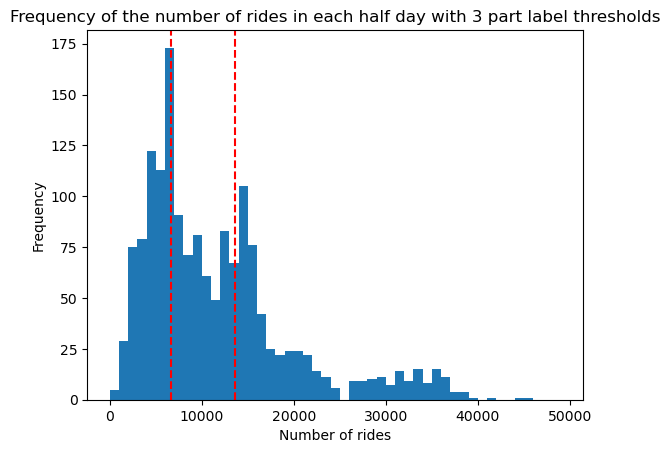

In [6]:
dist_plot()
for i in label3_split:
    plt.axvline(x=i, color='red', linestyle='dashed')
plt.title('Frequency of the number of rides in each half day with 3 part label thresholds')
plt.show()

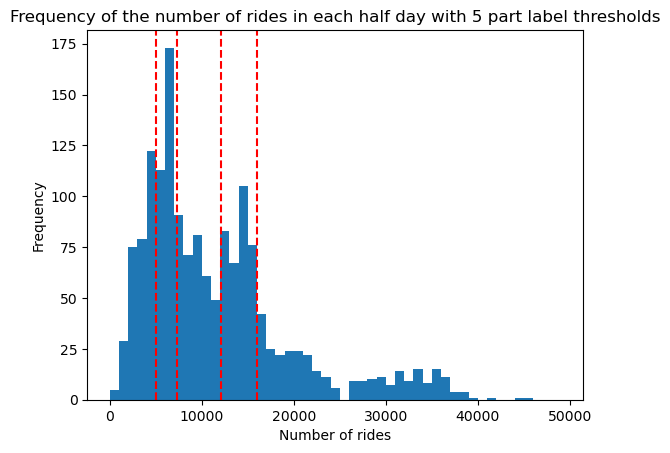

In [7]:
dist_plot()
for i in label5_split:
    plt.axvline(x=i, color='red', linestyle='dashed')
plt.title('Frequency of the number of rides in each half day with 5 part label thresholds')
plt.show()

The data table should now have values added in for these labels.

In [8]:
train_new['label3'] = np.select([train_new['rides_count']<label3_split[0],
                                 train_new['rides_count'].between(label3_split[0],label3_split[1])],
                                [1,2],3)
train_new['label5'] = np.select([train_new['rides_count']<label5_split[0],
                                 train_new['rides_count'].between(label5_split[0],label5_split[1]),
                                 train_new['rides_count'].between(label5_split[1],label5_split[2]),
                                 train_new['rides_count'].between(label5_split[2],label5_split[3])],
                                [1,2,3,4],5)

train_new.head()

,year,month,day,am_pm,rides_count,weekday,isHoliday,isWeekend,mean_temperature,total_precipitation,label3,label5
0,2014,4,15,False,742,1,False,False,5.6,9.0,1,1
1,2014,4,15,True,835,1,False,False,5.6,9.0,1,1
2,2014,4,16,False,2462,2,False,False,-3.4,0.0,1,1
3,2014,4,16,True,718,2,False,False,-3.4,0.0,1,1
4,2014,4,17,False,4178,3,False,False,2.4,0.0,1,1


Now need to carry out the same processing on the validation and test data and add the labels. Then both files can be saved.

In [9]:
valid_data = pd.read_csv("./data/preprocessed_data/valid.csv")

day_data = valid_data[day_data_cols].drop_duplicates(subset=day_data_cols, keep='first')
valid_new = valid_data[['year', 'month', 'day', 'am_pm', 'rides_count']].groupby(['year', 'month', 'day', 'am_pm'], as_index=False)['rides_count'].sum()
valid_new = valid_new.merge(day_data, how='left', on=['year', 'month', 'day'])

valid_new['label3'] = np.select([valid_new['rides_count']<label3_split[0],
                                 valid_new['rides_count'].between(label3_split[0],label3_split[1])],
                                [1,2],3)
valid_new['label5'] = np.select([valid_new['rides_count']<label5_split[0],
                                 valid_new['rides_count'].between(label5_split[0],label5_split[1]),
                                 valid_new['rides_count'].between(label5_split[1],label5_split[2]),
                                 valid_new['rides_count'].between(label5_split[2],label5_split[3])],
                                [1,2,3,4],5)

test_data = pd.read_csv("./data/preprocessed_data/test.csv")

day_data = test_data[day_data_cols].drop_duplicates(subset=day_data_cols, keep='first')
test_new = test_data[['year', 'month', 'day', 'am_pm', 'rides_count']].groupby(['year', 'month', 'day', 'am_pm'], as_index=False)['rides_count'].sum()
test_new = test_new.merge(day_data, how='left', on=['year', 'month', 'day'])

test_new['label3'] = np.select([test_new['rides_count']<label3_split[0],
                                 test_new['rides_count'].between(label3_split[0],label3_split[1])],
                                [1,2],3)
test_new['label5'] = np.select([test_new['rides_count']<label5_split[0],
                                 test_new['rides_count'].between(label5_split[0],label5_split[1]),
                                 test_new['rides_count'].between(label5_split[1],label5_split[2]),
                                 test_new['rides_count'].between(label5_split[2],label5_split[3])],
                                [1,2,3,4],5)

train_new.to_csv("data/preprocessed_data/t1_train.csv", index=False)
valid_new.to_csv("data/preprocessed_data/t1_valid.csv", index=False)
test_new.to_csv("data/preprocessed_data/t1_test.csv", index=False)

<a id='mods'></a>
## Models
[Back to contents](#content)

First to read in the data, for if the earlier cells have not been run.

In [2]:
train_new = pd.read_csv("./data/preprocessed_data/t1_train.csv")
valid_new = pd.read_csv("./data/preprocessed_data/t1_valid.csv")
test_new = pd.read_csv("./data/preprocessed_data/t1_test.csv")

### Splitting data for models

In [3]:
def t1_datasplit(train, valid, test):
    train_1 = train.copy()
    valid_1 = valid.copy()
    test_1 = test.copy()
    
    train_target_a = train_new['label3']
    train_target_b = train_new['label5']
    valid_target_a = valid_new['label3']
    valid_target_b = valid_new['label5']
    test_target_a = test_new['label3']
    test_target_b = test_new['label5']

    train_1 = train_1.drop(columns=['rides_count', 'label3', 'label5', 'year', 'day'])
    valid_1 = valid_1.drop(columns=['rides_count', 'label3', 'label5', 'year', 'day'])
    test_1 = test_1.drop(columns=['rides_count', 'label3', 'label5', 'year', 'day'])
    
    return train_1, train_target_a, train_target_b, valid_1, valid_target_a, valid_target_b, test_1, test_target_a, test_target_b


### Baseline

Can now calculate a baseline for each of the 3 and 5 label set ups, using the proportion of the majority label in the test data.

In [12]:
train_1, train_target_a, train_target_b, valid_1, valid_target_a, valid_target_b, test_1, test_target_a, test_target_b = t1_datasplit(train_new, valid_new, test_new)

from collections import Counter
test_count3 = Counter(test_target_a)
test_count5 = Counter(test_target_b)

total3 = 0
max3 = 0
total5 = 0
max5 = 0
for key, value in test_count3.items():
    total3 += value
    if value> max3:
        max3=value
for key, value in test_count5.items():
    total5 += value
    if value> max5:
        max5=value
        
print("3 label baseline: ", max3/total3)
print("5 label baseline: ", max5/total5)
print(test_count3)
print(test_count5)

3 label baseline:  0.5915841584158416
5 label baseline:  0.46534653465346537
Counter({3: 239, 2: 139, 1: 26})
Counter({5: 188, 4: 111, 3: 73, 2: 19, 1: 13})


### Define models

In [5]:
# KNN
def knn_t1(train, valid, test, n_range, label_set):
    train_1, train_target_a, train_target_b, valid_1, valid_target_a, valid_target_b, test_1, test_target_a, test_target_b = t1_datasplit(train, valid, test)
    
    if label_set=='a':
        train_target = train_target_a
        valid_target = valid_target_a
        test_target = test_target_a
    else:
        train_target = train_target_b
        valid_target = valid_target_b
        test_target = test_target_b

    # create the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', preprocessing.StandardScaler(), ['mean_temperature', 'total_precipitation']),
            ('encoder', preprocessing.OneHotEncoder(), ['am_pm', 'isHoliday', 'isWeekend', 'month']) ])

    best_n = 1
    best_acc = 0
    # choose the estimator and define a pipeline
    for n in n_range:
        estimator = KNeighborsClassifier(n_neighbors=n)
        pipeline = Pipeline([ ('preprocessing', preprocessor), ('classification', estimator) ])
        pipeline.fit(train_1, train_target)
        val_predict = pipeline.predict(valid_1)
        val_acc = accuracy_score(valid_target, val_predict)
        if val_acc>best_acc:
            best_n = n
            best_acc = val_acc
    
    # run with best
    train_all = pd.concat([train_1, valid_1])
    train_target_all = pd.concat([train_target, valid_target])
    estimator = KNeighborsClassifier(n_neighbors=best_n)
    pipeline = Pipeline([ ('preprocessing', preprocessor), ('classification', estimator) ])
    pipeline.fit(train_all, train_target_all)
    test_pred = pipeline.predict(test_1)
    
    output = test.copy()
    output['pred']=test_pred
    output['actual']=test_target
    filename = 'results/t1_knn_'+label_set+'_n'+str(best_n)+'.csv'
    output.to_csv(filename, index=False)
    

In [18]:
# Decision tree
def dt_t1(train, valid, test, depth_range, label_set):
    train_1, train_target_a, train_target_b, valid_1, valid_target_a, valid_target_b, test_1, test_target_a, test_target_b = t1_datasplit(train, valid, test)
    
    if label_set=='a':
        train_target = train_target_a
        valid_target = valid_target_a
        test_target = test_target_a
    else:
        train_target = train_target_b
        valid_target = valid_target_b
        test_target = test_target_b
    
    best_depth = 1
    best_acc = 0
    # choose the estimator and define a pipeline
    for n in depth_range:
        model = tree.DecisionTreeClassifier(max_depth=n)
        model.fit(train_1, train_target)
        val_predict = model.predict(valid_1)
        val_acc = accuracy_score(valid_target, val_predict)
        if val_acc>best_acc:
            best_depth = n
            best_acc = val_acc
            
    train_all = pd.concat([train_1, valid_1])
    train_target_all = pd.concat([train_target, valid_target])
    model = tree.DecisionTreeClassifier(max_depth=best_depth)
    model.fit(train_all, train_target_all)
    test_pred = model.predict(test_1)
    
    output = test.copy()
    output['pred']=test_pred
    output['actual']=test_target
    filename = 'results/t1_dt_'+label_set+'_n'+str(best_depth)+'.csv'
    output.to_csv(filename, index=False)
    

### Run models

In [6]:
random.seed(33)
knn_t1(train_new, valid_new, test_new, range(1,201,1), 'a')
knn_t1(train_new, valid_new, test_new, range(1,201,1), 'b')

In [34]:
random.seed(33)
dt_t1(train_new, valid_new, test_new, range(11,51,1), 'a')
dt_t1(train_new, valid_new, test_new, range(11,51,1), 'b')

## Evaluation

In [8]:
a_eval_files = ['results/t1_knn_a_n101.csv', 'results/t1_dt_a_n11.csv']
b_eval_files = ['results/t1_knn_b_n194.csv', 'results/t1_dt_b_n11.csv']
models = ['KNN', 'Decision Tree']

In [9]:
def t1_evaluate(filepath):
    res = pd.read_csv(filepath)
    actual_values = res['actual']
    predicted_values = res['pred']
    acc = accuracy_score(actual_values, predicted_values)
    prec = precision_score(actual_values, predicted_values, average='macro')
    f1 = f1_score(actual_values, predicted_values, average='macro')
    return acc, prec, f1  

def compare_results_t1(result_files, models, label_type):    
    results = []
    for i in range(len(result_files)):
        acc, prec, f1 = t1_evaluate(result_files[i])
        result = {
            'Model': models[i],
            'Accuracy': acc,
            'Precision': prec,
            'F1': f1
        }
        results.append(result)
    
    results_df = pd.DataFrame(results)
    filename = 'results/evaluation_t1'+label_type+'.csv'
    results_df.to_csv(filename, index=False)
    print(results_df)

In [10]:
compare_results_t1(a_eval_files, models, 'a')
compare_results_t1(b_eval_files, models, 'b')

           Model  Accuracy  Precision        F1
0            KNN   0.59901   0.555556  0.524116
1  Decision Tree   0.54703   0.503807  0.469946
           Model  Accuracy  Precision        F1
0            KNN  0.460396   0.272283  0.281539
1  Decision Tree  0.356436   0.277047  0.246639


/Users/abigailhayes/opt/anaconda3/envs/DM_FSS23/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion matrix

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [11]:
def cm_help(filepath, label_type):
    res = pd.read_csv(filepath)
    cnf_matrix = confusion_matrix(res['actual'], res['pred'])
    np.set_printoptions(precision=2)
    if label_type=='a':
        classes = ['Low', 'Medium', 'High']
    else:
        classes = ['Very low', 'Low', 'Medium', 'High', 'Very high']
    plot_confusion_matrix(cnf_matrix, classes=classes)

KNN model:


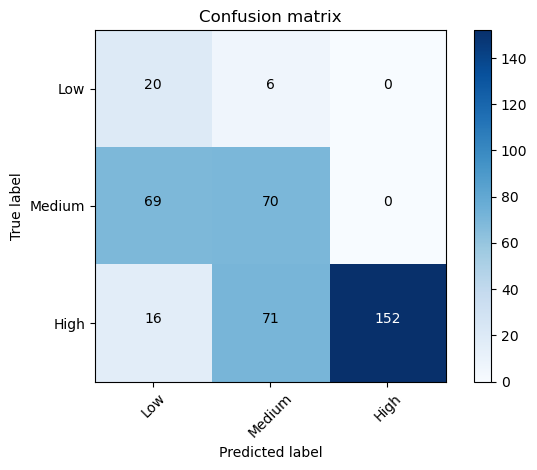

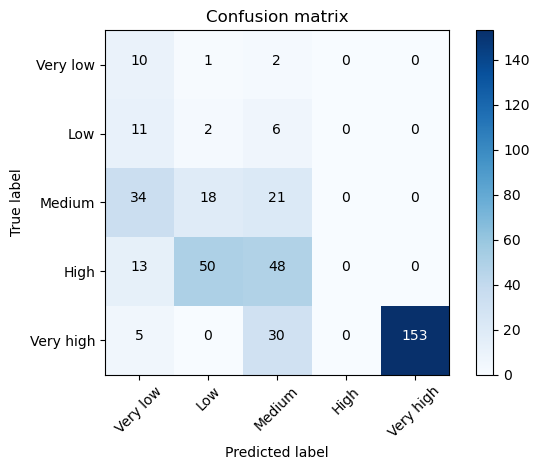

In [12]:
print("KNN model:")
cm_help(a_eval_files[0], 'a')
cm_help(b_eval_files[0], 'b')

DT model:


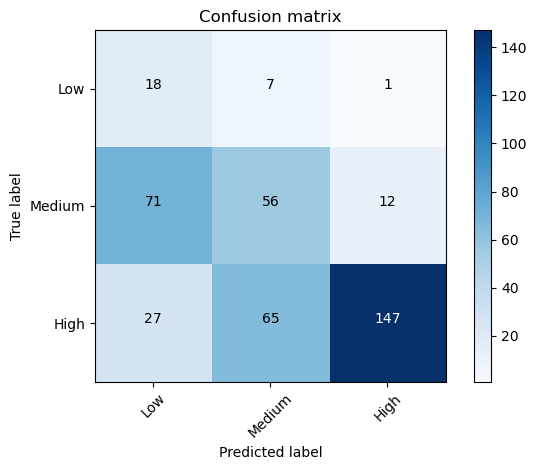

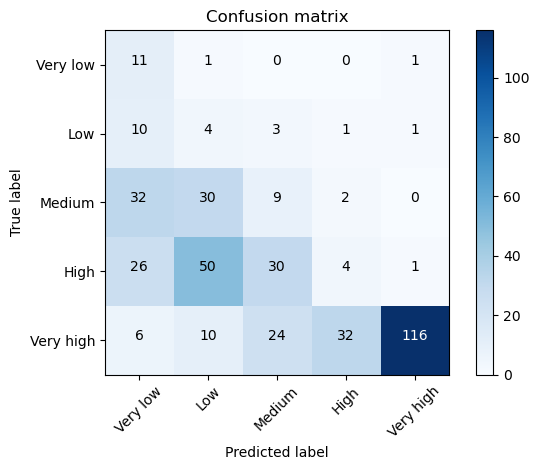

In [30]:
print("DT model:")
cm_help(a_eval_files[1], 'a')
cm_help(b_eval_files[1], 'b')